# Ride Service Exploration

## Import Libraries

In [2]:
# constants 
import sys
sys.path.insert(1, '..')
import src.constants as cst

# general
import pandas as pd
import numpy as np 
import datetime
from collections import Counter

# plots
import seaborn as sns
import matplotlib.colors as mpl_col
import matplotlib.pyplot as plt
sns.set()

#machine learning and statistical methods
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

from sklearn.metrics import mean_absolute_error

# settings
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (16, 8)

/Users/marthab/.pyenv/versions/ride_demand_prediction/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/z0/x8p7hmr50s5ff0l4lsmb_z300000gn/T/ipykernel_54481/2940386392.py:31: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## Load data 

In [14]:
df = pd.read_csv(cst.NYC_TOTAL_RIDES, sep=",", index_col=0)
df.head()

date  nb_rides
0  2018-01-01  702084.0
1  2018-01-02  547447.0
2  2018-01-03  583735.0
3  2018-01-04  354626.0
4  2018-01-05  699966.0

## Exploratory Data Analysis

In [4]:
df.shape

(825, 2)

In [5]:
df['nb_rides'].describe()

count    8.250000e+02
mean     7.271177e+05
std      1.221185e+05
min      1.000000e+00
25%      6.695780e+05
50%      7.263160e+05
75%      7.946080e+05
max      1.039874e+06
Name: nb_rides, dtype: float64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 825 entries, 0 to 824
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      825 non-null    object 
 1   nb_rides  825 non-null    float64
dtypes: float64(1), object(1)
memory usage: 19.3+ KB


In [7]:
# how many missing dates 
# earliest and latest date
date_start = df['date'].min()
date_end = df['date'].max()
missing_dates = pd.date_range(start = date_start, end = date_end ).difference(df['date'])
print(F"Start and end date: {date_start, date_end}")
print(f"length date range: {len(pd.date_range(start = date_start, end = date_end ))}")
print(f"length missing dates: {len(missing_dates)}")

Start and end date: ('2018-01-01', '2020-03-31')
length date range: 821
length missing dates: 0


### Prep

In [8]:
# convert date to datetime
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# sort by date
df.sort_values(by=['date'], inplace=True)

# add month and year as seperate columns
df['year'] = pd.to_datetime(df['date']).dt.year
df['month'] = pd.to_datetime(df['date']).dt.month

# add weekday information
df['week_day'] = pd.to_datetime(df['date']).dt.strftime('%A')

In [9]:
df.tail()

date  nb_rides  year  month  week_day
820 2020-03-27  184297.0  2020      3    Friday
821 2020-03-28  156564.0  2020      3  Saturday
822 2020-03-29  127639.0  2020      3    Sunday
823 2020-03-30  154304.0  2020      3    Monday
824 2020-03-31  149782.0  2020      3   Tuesday

### Time Series Plots

In [10]:
# plot entire time series of one store
def plot_df(x, y, title="", xlabel='Date', ylabel='Number of Drives', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

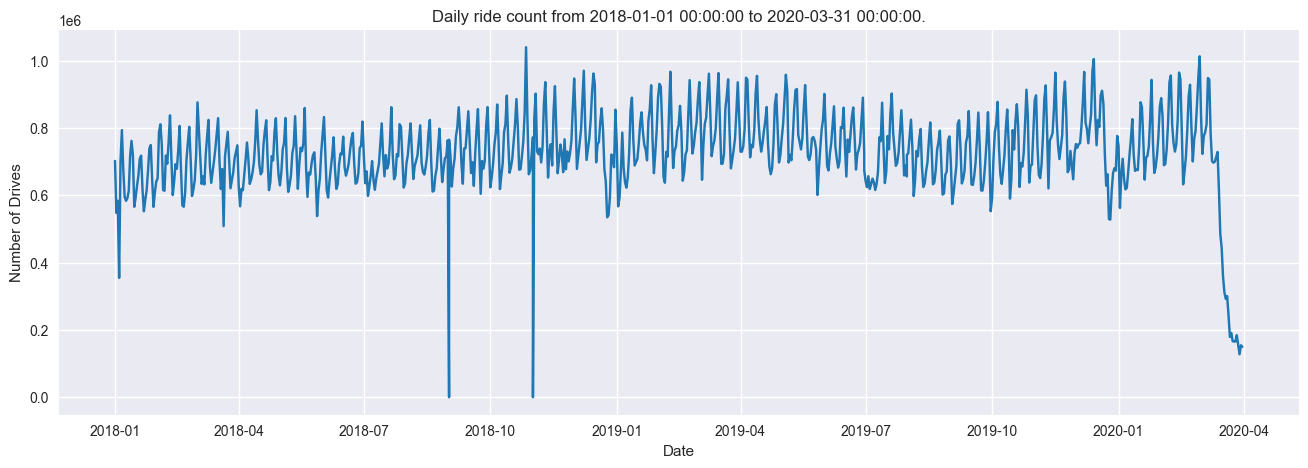

In [11]:
plot_df(x=df['date'], y=df['nb_rides'], title=f"Daily ride count from {df['date'].min()} to {df['date'].max()}.")    

In [65]:
df[df['nb_rides']<50000]

date  nb_rides  year  month  week_day
244 2018-09-01       1.0  2018      9  Saturday
306 2018-11-01       1.0  2018     11  Thursday

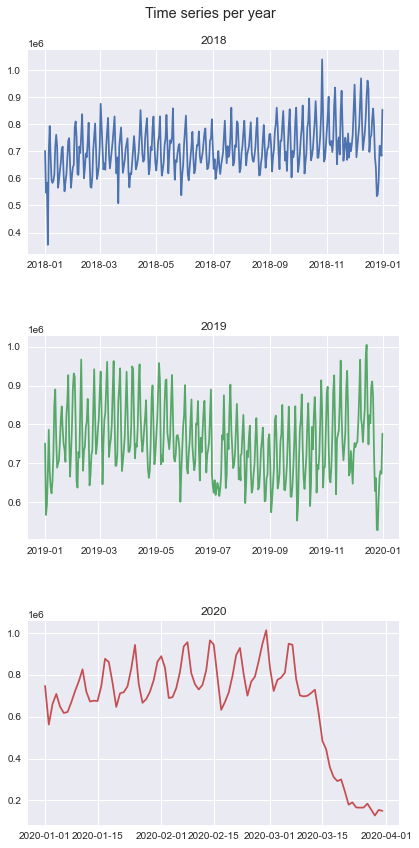

In [37]:
# plot time series per year of one store
ride_filt = df['nb_rides']>50000
years = df['year'].unique()

# initiate subplots
fig, axs = plt.subplots(len(years), figsize=(6, 12))
fig.suptitle(f"Time series per year")
colors = plt.rcParams["axes.prop_cycle"]()

# plot time series for each year
axis = 0
for year in years:
    filt = df['year']==year
    c = next(colors)["color"]
    axs[axis].plot(df[(ride_filt) & (filt)]['date'], df[(ride_filt) & (filt)]['nb_rides'], color=c)
    axs[axis].set_title(f"{year}")
    axis += 1
    
# set the spacing between subplots
fig.tight_layout()
plt.subplots_adjust(top=0.93, hspace=0.4)
plt.show()

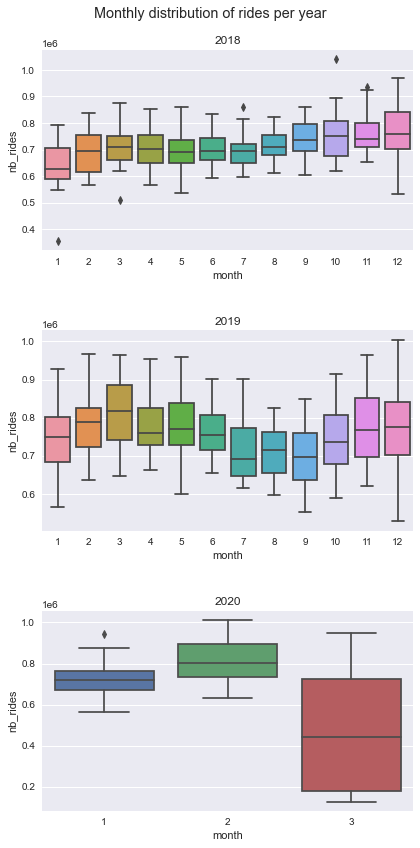

In [38]:
# Boxplot monthly dist of visitor count, for each year 
years = df['year'].unique()

# initiate subplots
fig, axs = plt.subplots(len(years), figsize=(6, 12))
fig.suptitle(f"Monthly distribution of rides per year")
colors = plt.rcParams["axes.prop_cycle"]()

# plot time series for each year
axis = 0
for year in years:
    filt = df['year']==year
    c = next(colors)["color"]
    sns.boxplot(data=df[(ride_filt) & (filt)], x='month', y='nb_rides', orient='v', ax=axs[axis])
    axs[axis].set_title(f"{year}")
    axis += 1

# set the spacing between subplots
fig.tight_layout()
plt.subplots_adjust(top=0.93, hspace=0.4)
plt.show()

Text(0.5, 1.0, 'Distribution of daily rides for each month')

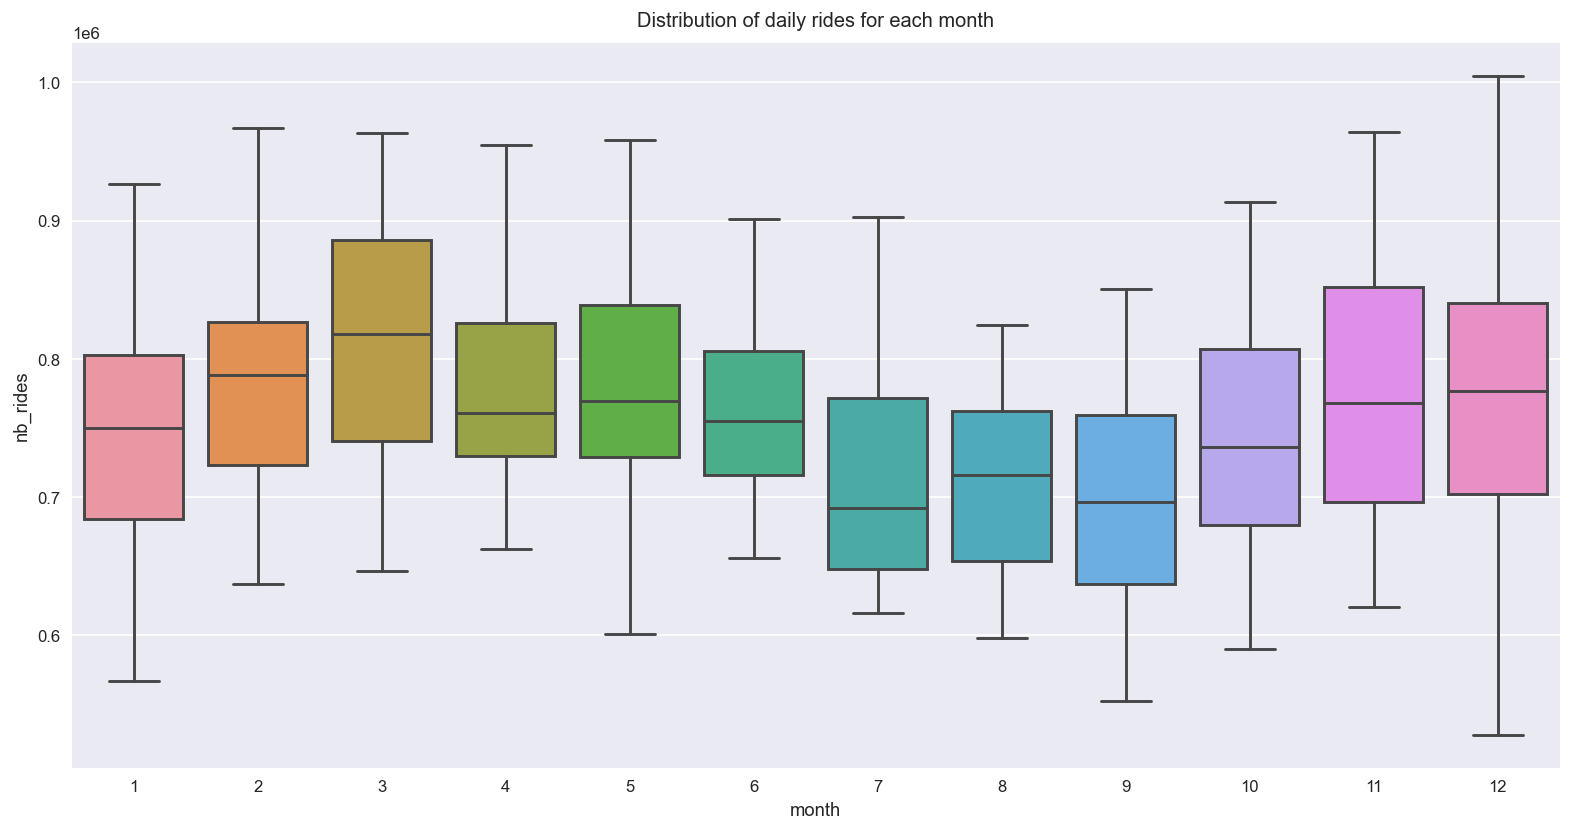

In [46]:
# Boxplot monthly dist of visitor count, for all years together
sns.boxplot(data=df[df['year']==2019], x='month', y='nb_rides').set_title('Distribution of daily rides for each month')

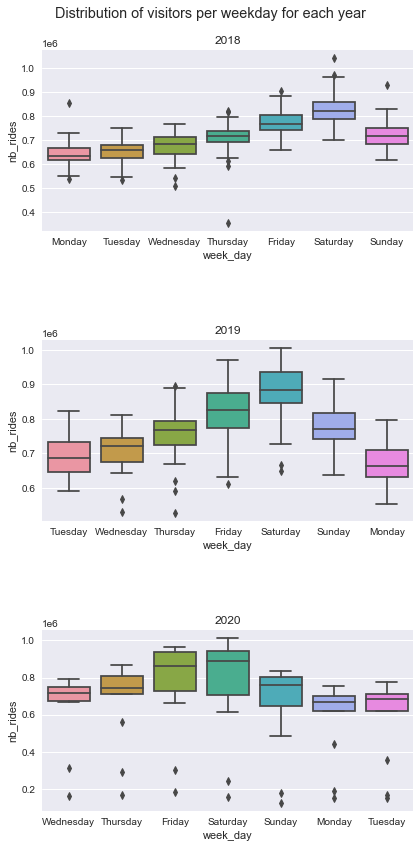

In [44]:
# Boxplot dist of visitor count per weekday, for each year 
years = df['year'].unique()
ride_filt = df['nb_rides']>50000

# initiate subplots
fig, axs = plt.subplots(len(years), figsize=(6, 12))
fig.suptitle(f"Distribution of visitors per weekday for each year")
colors = plt.rcParams["axes.prop_cycle"]()

# plot time series for each year
axis = 0
for year in years:
    filt = (ride_filt) & (df['year']==year) 
    c = next(colors)["color"]
    sns.boxplot(data=df[filt], x='week_day', y='nb_rides', orient='v', ax=axs[axis])
    axs[axis].set_title(f"{year}")
    axis += 1

# set the spacing between subplots
fig.tight_layout()
plt.subplots_adjust(top=0.93, hspace=0.6)
plt.show()

Text(0.5, 1.0, 'Distribution of rides per week day')

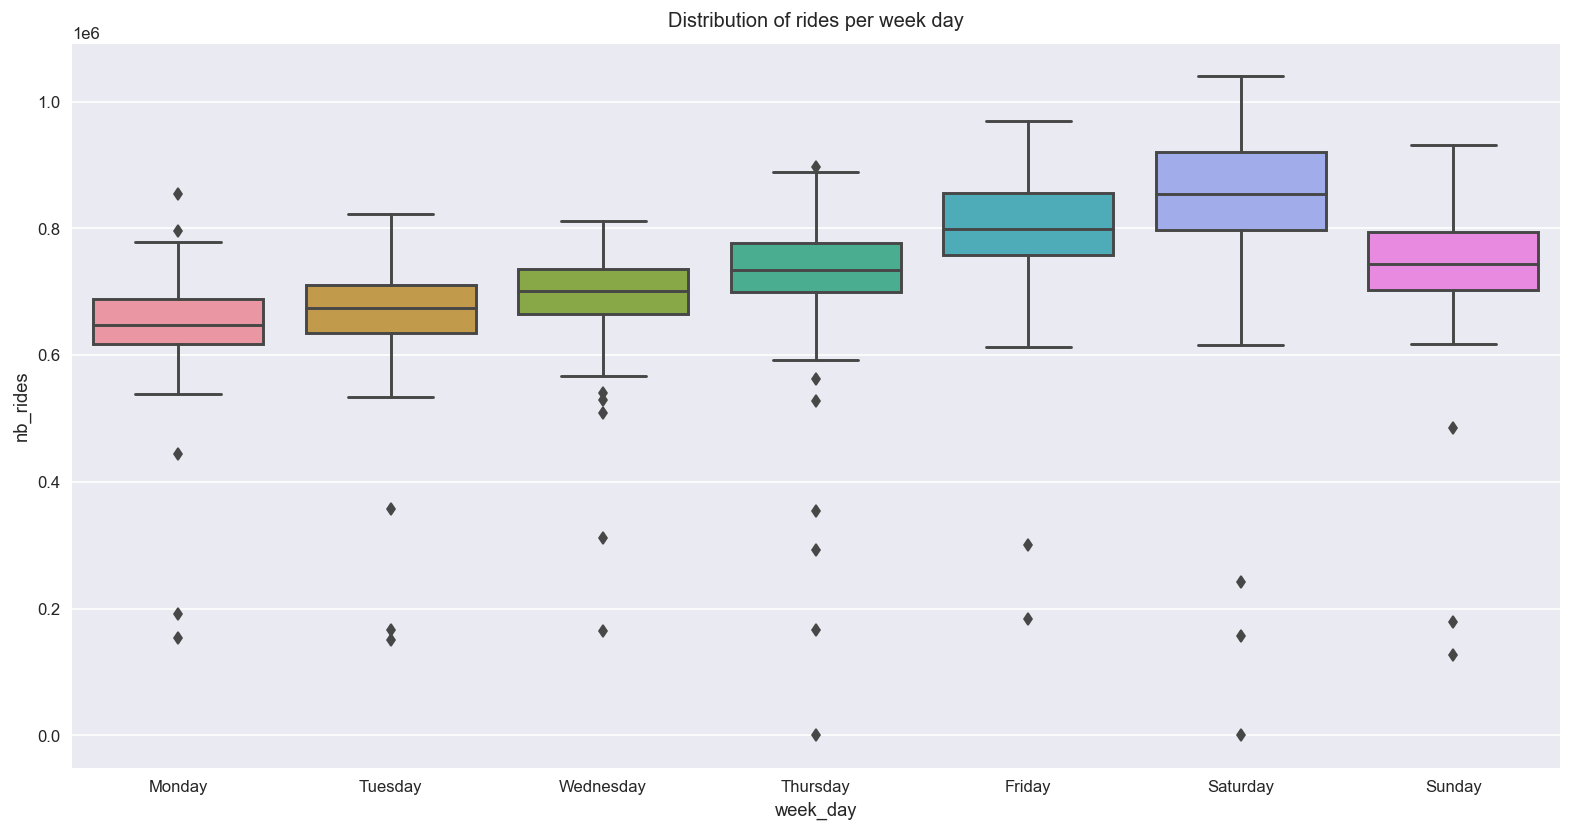

In [44]:
# Boxplot monthly dist of visitor count, for all years together 
sns.boxplot(data=df, x='week_day', y='nb_rides').set_title('Distribution of rides per week day')

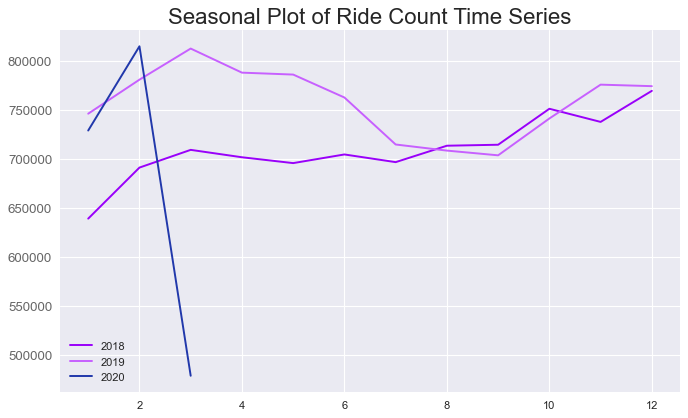

In [47]:
# create df with avg ride count grouped month 
df_month = df[['year', 'month', 'nb_rides']].sort_values(['year', 'month']).groupby(['year', 'month'], as_index=False).mean()


# Prep Colors
np.random.seed(100)
mycolors = np.random.choice(list(mpl_col.XKCD_COLORS.keys()), len(df_month.sort_values('year')['year'].unique()), replace=False)

# Draw Plot
plt.figure(figsize=(10,6), dpi= 80)
for i, y in enumerate(df_month['year'].unique()): 
    plt.plot('month', 'nb_rides', data=df_month.loc[df_month['year']==y, :], color=mycolors[i], label=y)
    

# graph settings
#plt.gca().set(xlim=(-0.3, 11), ylim=(2, 30), ylabel='$Avg visitor count$', xlabel='$Month$')
plt.yticks(fontsize=12, alpha=.7)
plt.legend()
plt.title(f"Seasonal Plot of Ride Count Time Series", fontsize=20)
plt.show()

### Autocorrelation Plots

Correlation between time series and lagged values (from previous points in time)

Autocorrelation function (ACF) considers all time series components (trends, seasonality etc)

Partial autocorrelation function (PACF) considers correlation between residuals (without component effects)

''

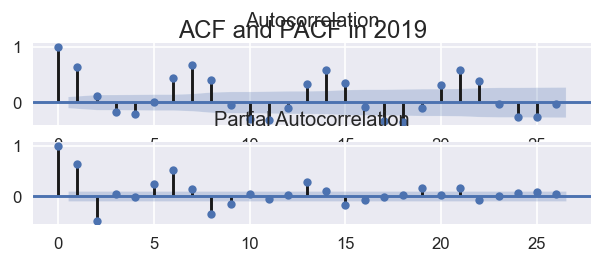

In [54]:
# Autocorrelation plot for one shop in one specific year
year = 2019
filt_year = df['year']==year

fig, ax = plt.subplots(2)
plot_acf(df[filt_year]['nb_rides'], ax=ax[0])
plot_pacf(df[filt_year]['nb_rides'], ax=ax[1])
fig.suptitle(f"ACF and PACF in {year}")
;

Repeated spikes in the ACF graph can indicate seasonal patterns

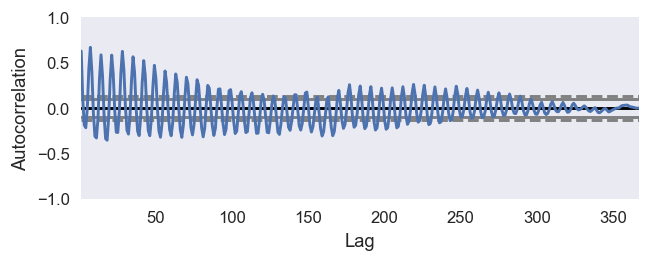

In [50]:
from pandas.plotting import autocorrelation_plot

# Draw Plot
plt.rcParams.update({'figure.figsize':(6,2), 'figure.dpi':120})
autocorrelation_plot(df[filt_year]['nb_rides'].tolist())

### Decomposition Plot

/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/seasonal.py:304: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout()


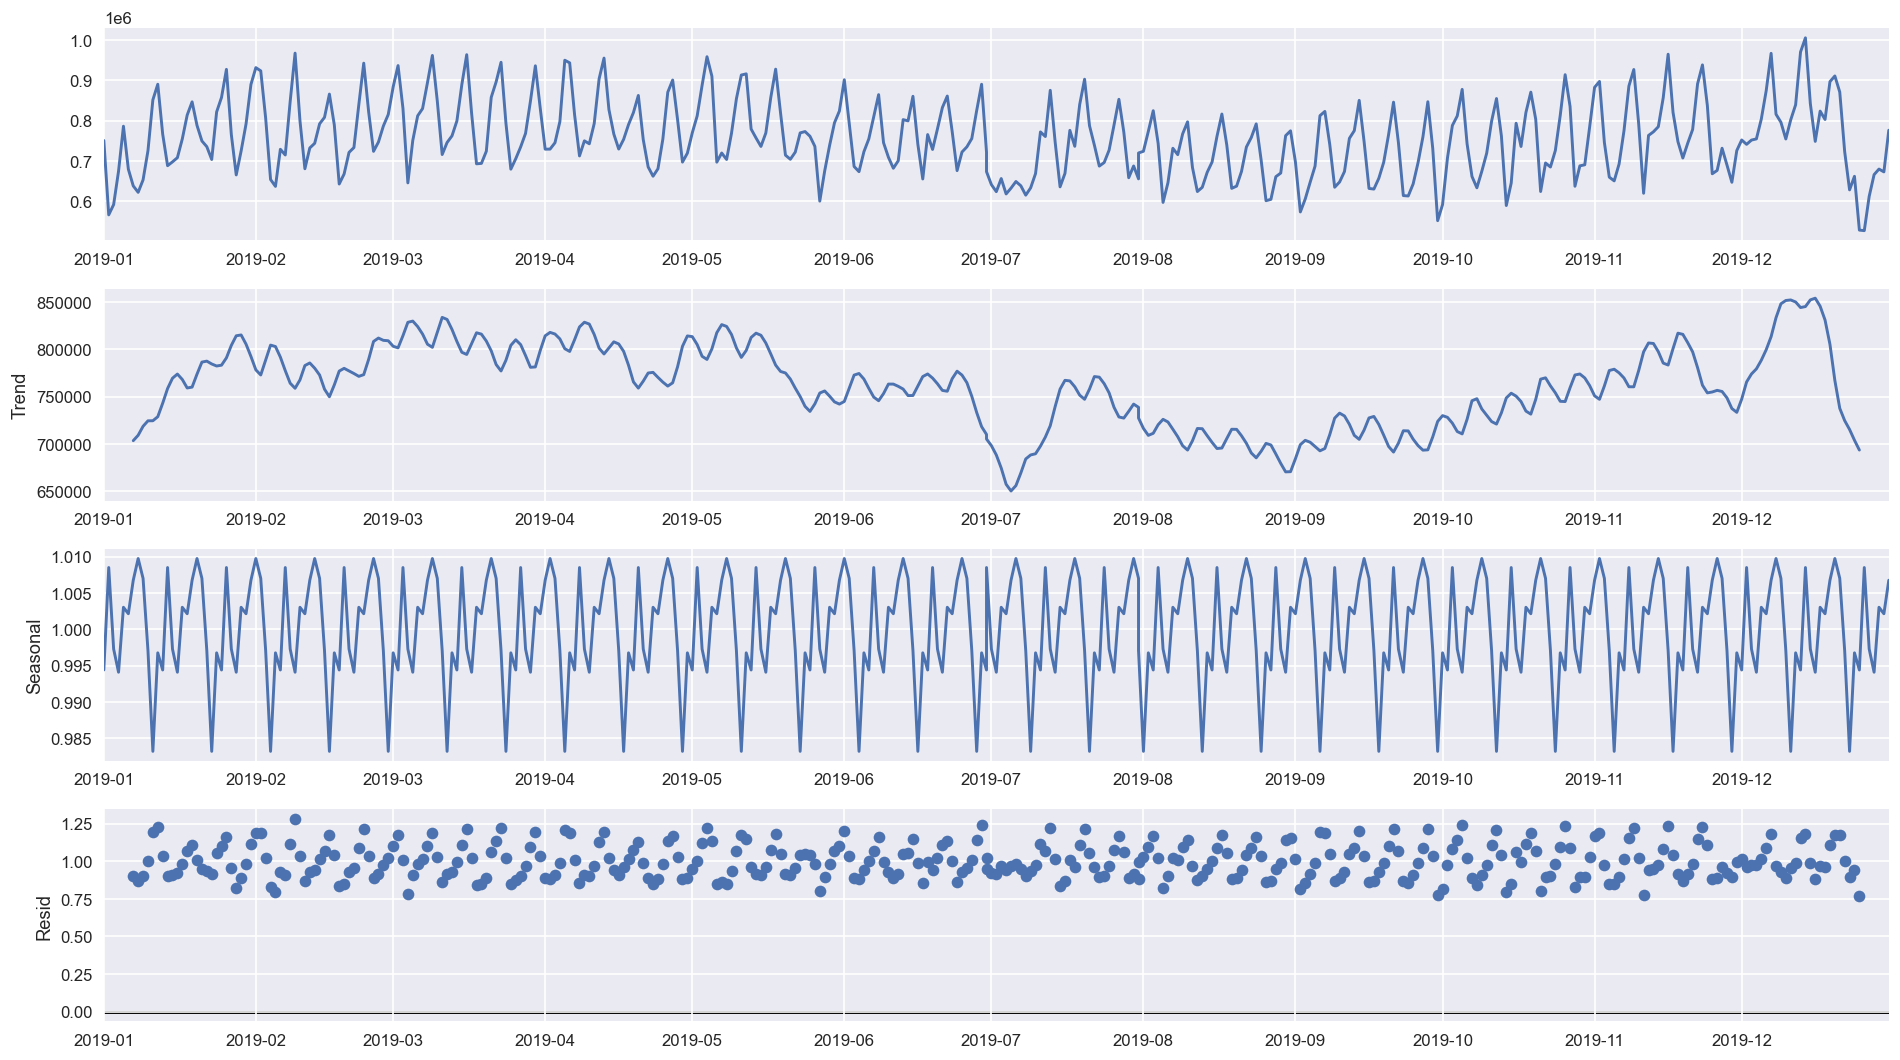

In [15]:
# Decomposition plot for one year
year = 2019
filt_year = df['year']==year
decom_method ='multiplicative'

#decom_df = df[(filt_store) & (filt_year)][['Date', 'VISITOR_COUNT']].set_index('Date')

decom_df = df[filt_year][['date', 'nb_rides']].set_index('date')

decomposition = seasonal_decompose(decom_df, 
                                   model=decom_method, 
                                   period=12)
fig = decomposition.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show();

### Seasonality 

In [18]:
# start sample always on monday 
monday_filt = df['week_day']=='Monday'

#drawing a random sample of 5 indices (dates) without repetition from sub sample
sample = sorted([x for x in np.random.choice([x for x in df[monday_filt].index[:-10]],5,replace=False)])

#checking persistence of daily seasonality by inspecting 5 random time window of 10 days
f, axes = plt.subplots(len(sample),1,dpi=200,figsize=(10,18));
f.tight_layout(pad=3.0)
plt.suptitle('Random time window samples with duration of 10 days for inspecting daily seasonal effect', y = 1.01, fontsize=24)

#plotting time windows and drawing vertical lines at 04:00 each day
for si,s in enumerate(sample):
    ids = df.index.to_list().index(s)
    idx = [df.iloc[x:x+1,:].index.values for x in range(ids, ids + 10)]
    df.iloc[ids:(ids+10),:].plot(ax=axes[si], legend=False, rot=70, ylabel='Rides');

ValueError: view limit minimum -38306.25 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 2000x3600 with 5 Axes>

In [16]:
# working only with pre-covid data
filt_year = df['year'].isin([2018, 2019])
nocovid_df = df[filt_year]

In [66]:
# seasonal decompostion
#splitting time series to train and test 
#size = int(len(df['nb_rides']) * 0.8)
train, test = nocovid_df['nb_rides'].to_frame(), nocovid_df['nb_rides'].to_frame()

#extracting weekly seasonality from raw time series
sd_7 = sm.tsa.seasonal_decompose(train.values, model='additive', period=7)

#extracting yearly seasonality from time series adjusted by weekly seasonality
sd_365 = sm.tsa.seasonal_decompose(train.values - np.array(sd_7.seasonal).reshape(-1,1), model='additive', period=365)

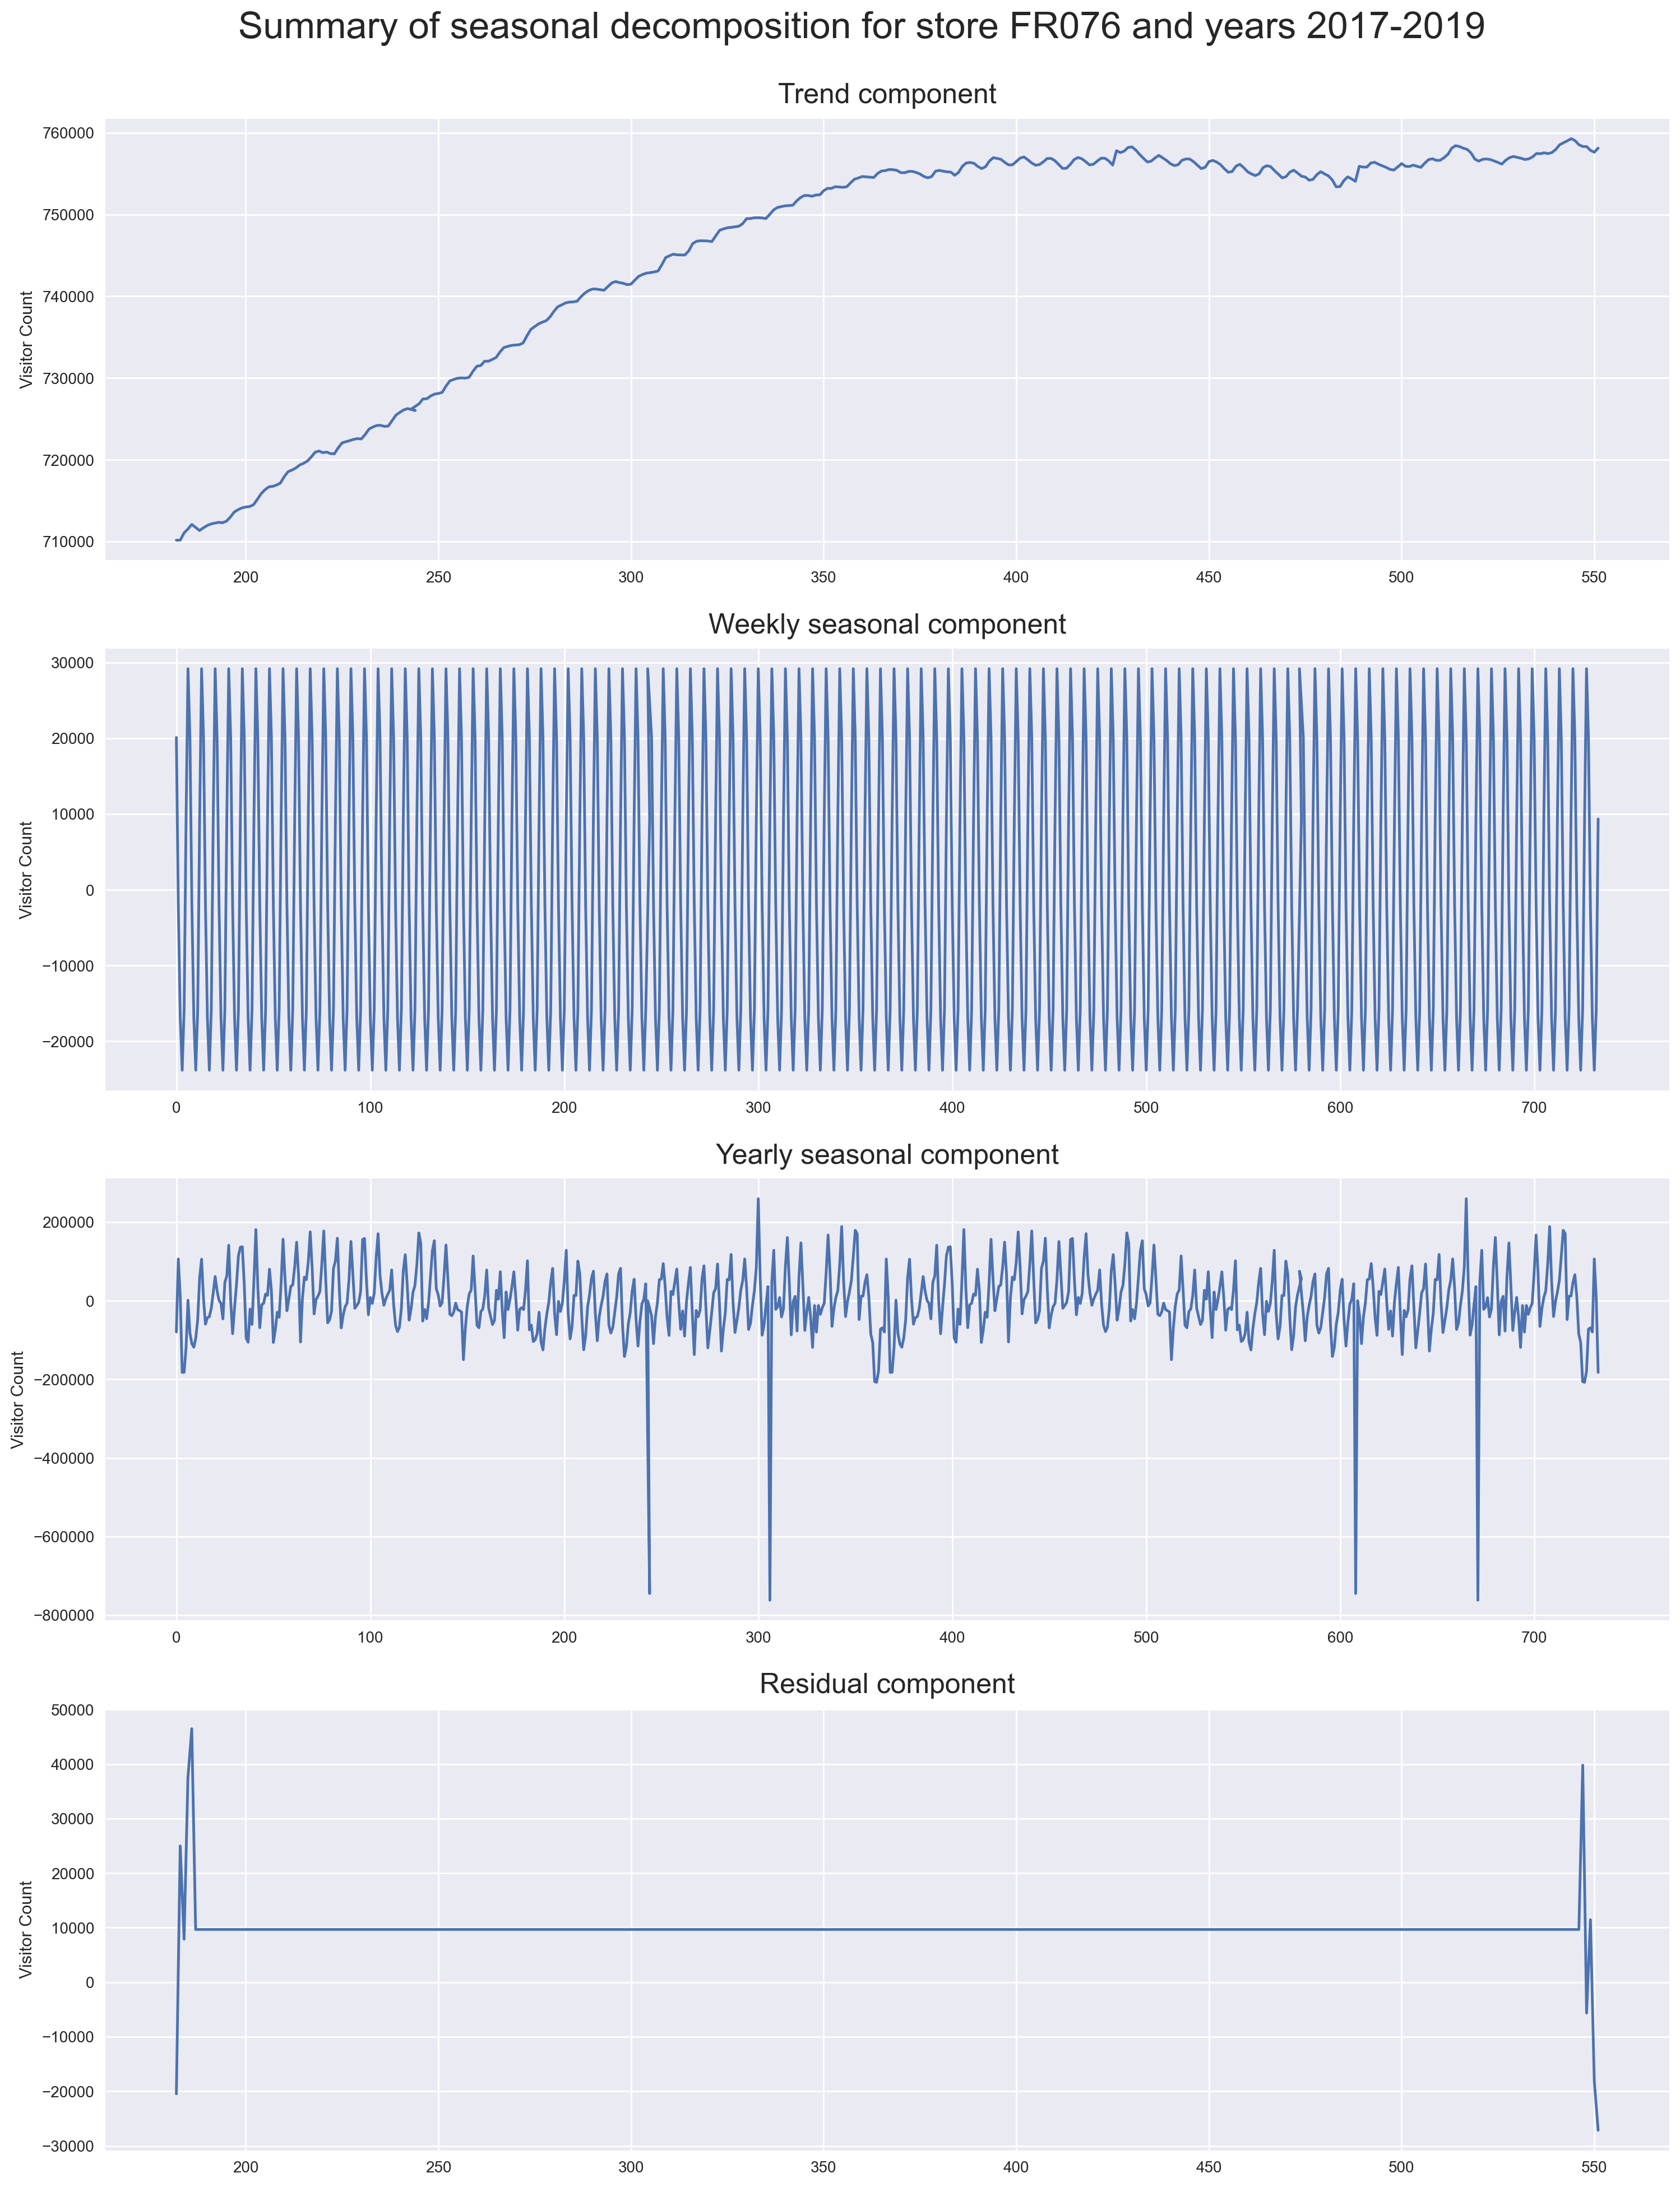

In [67]:
#drawing figure with subplots, predefined size and resolution
f, axes = plt.subplots(4,1,figsize=(18,24),dpi=200);

#setting figure title and adjusting title position and size
plt.suptitle(f'Summary of seasonal decomposition for store {store} and years 2017-2019', y=0.92, fontsize=24);

#plotting trend component
axes[0].plot(train.index, sd_365.trend)
axes[0].set_title('Trend component', fontdict={'fontsize': 18});


#plotting weekly seasonal component
axes[1].plot(train.index, sd_7.seasonal);
axes[1].set_title('Weekly seasonal component', fontdict={'fontsize': 18});


#plotting yearly seasonality
axes[2].plot(train.index, sd_365.seasonal);
axes[2].set_title('Yearly seasonal component', fontdict={'fontsize': 18});


#plotting residual of decomposition
axes[3].plot(train.index, sd_365.resid);
axes[3].set_title('Residual component', fontdict={'fontsize': 18});

#setting label for each y axis
for a in axes:
    a.set_ylabel('Visitor Count');
    
plt.show();

/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


''

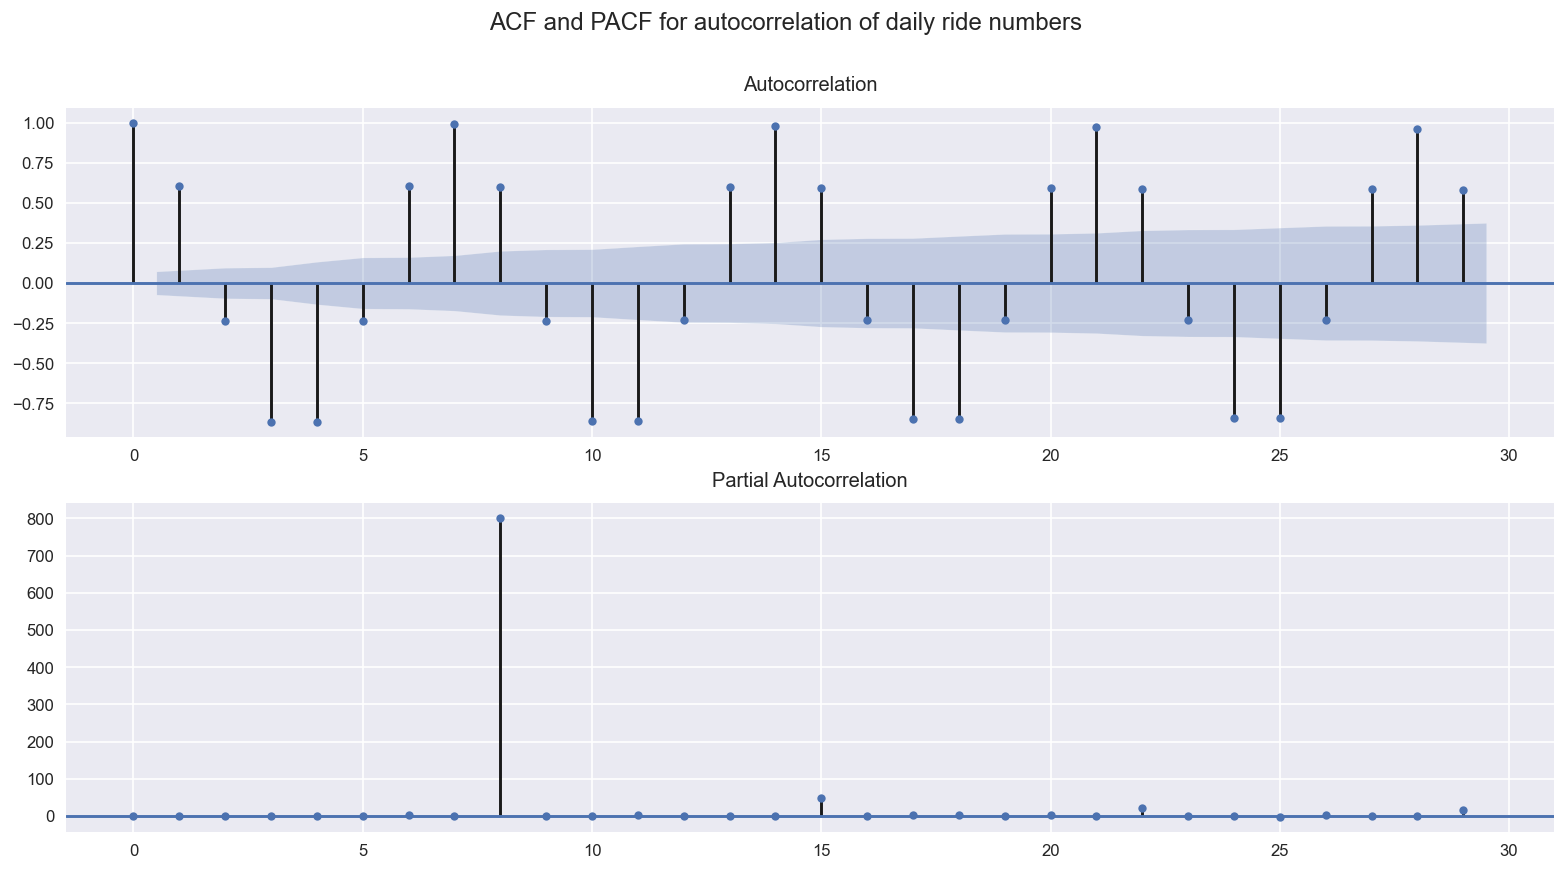

In [70]:
fig, ax = plt.subplots(2)
plot_acf(sd_7.seasonal, ax=ax[0])
plot_pacf(sd_7.seasonal, ax=ax[1])
fig.suptitle(f"ACF and PACF for autocorrelation of daily ride numbers")
;

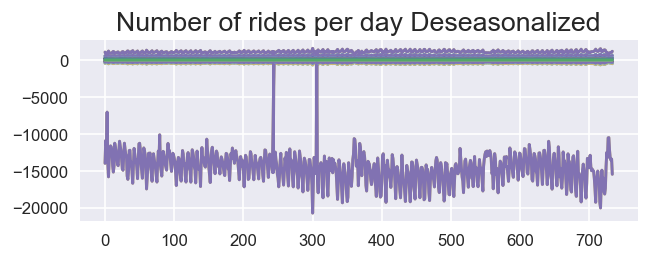

In [26]:
# Deseasonalize
deseasonalized = train.values / sd_365.seasonal

# Plot
plt.plot(train.index, deseasonalized)
plt.title(f"Number of rides per day Deseasonalized", fontsize=16)
plt.plot();

### Stationarity 

A time series is stationary if its statistical properties do not change over time. To be stationary a dataset must show a constant mean and variance value over the entire time frame

Augmented Dickey Fuller Test: null-hypothesis --> time series not stationary, reject if p<0.05

In [30]:
from statsmodels.tsa.stattools import adfuller, kpss

# filters
# working only with pre-covid data
filt_year = df['year'].isin([2018, 2019])
filt_df = df[filt_year].set_index('date')

# ADF Test
result = adfuller(filt_df['nb_rides'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -3.587369622685589
p-value: 0.00600713542344648
Critial Values:
   1%, -3.43955476721974
Critial Values:
   5%, -2.865602155751202
Critial Values:
   10%, -2.5689331692727135


The time series is stationary

### Detrend

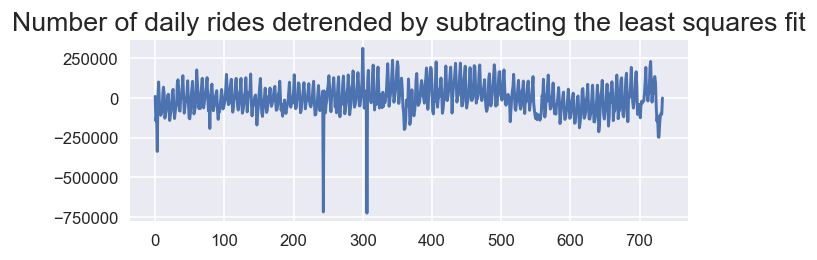

In [32]:
# Detrend: Subtract the line of best fit
# get line of best fit?
from scipy import signal


detrended = signal.detrend(filt_df['nb_rides'].values)
fig = plt.plot(detrended)
plt.title(f"Number of daily rides detrended by subtracting the least squares fit", fontsize=16)
plt.show();

### Deseasonalize 

[]

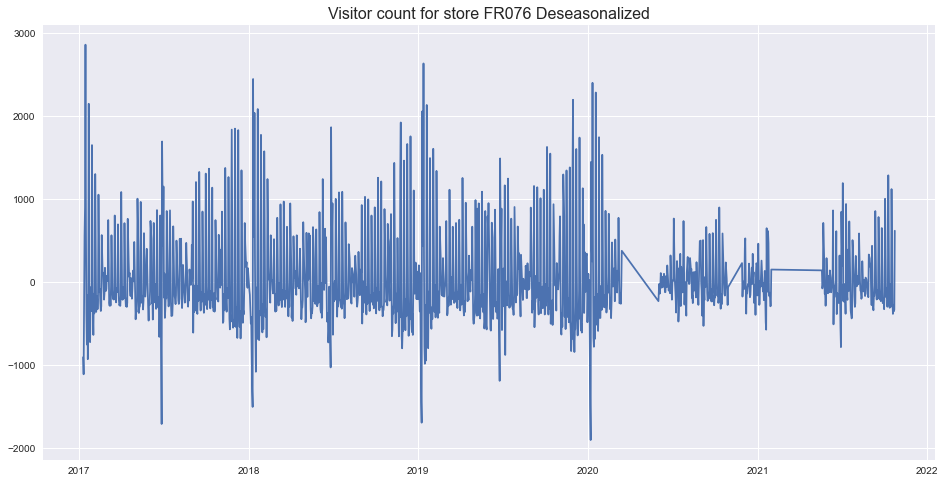

In [166]:
# Time Series Decomposition

# Detrend
detrended = filt_df[corr_filt]['VISITOR_COUNT'].values - result_mul.trend

# Deseasonalize
deseasonalized = detrended / result_mul.seasonal

# Plot
plt.plot(deseasonalized)
plt.title(f"Visitor count for store {store} Deseasonalized", fontsize=16)
plt.plot()


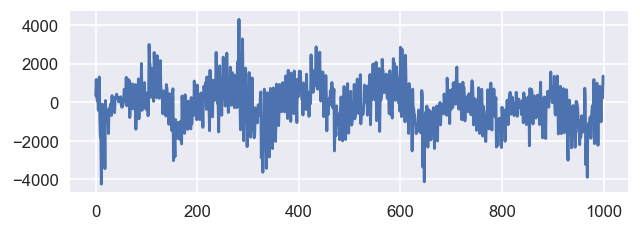

In [72]:
# seasonal adjustments with differencing

# filters
store = 'FR076'
filt_store = df['STORE_CODE']==store
filt_df = df[filt_store][['Date', 'VISITOR_COUNT']].set_index('Date')
X = filt_df.values

diff = list()
days_in_year = 365
for i in range(days_in_year, len(X)):
	value = X[i] - X[i - days_in_year]
	diff.append(value)
plt.plot(diff)
plt.show()

In [70]:
range(days_in_year, len(filt_df))

range(365, 1365)

### Lag plot 

Scatter plot of a time series against a lag of itself to check for autocorrelation

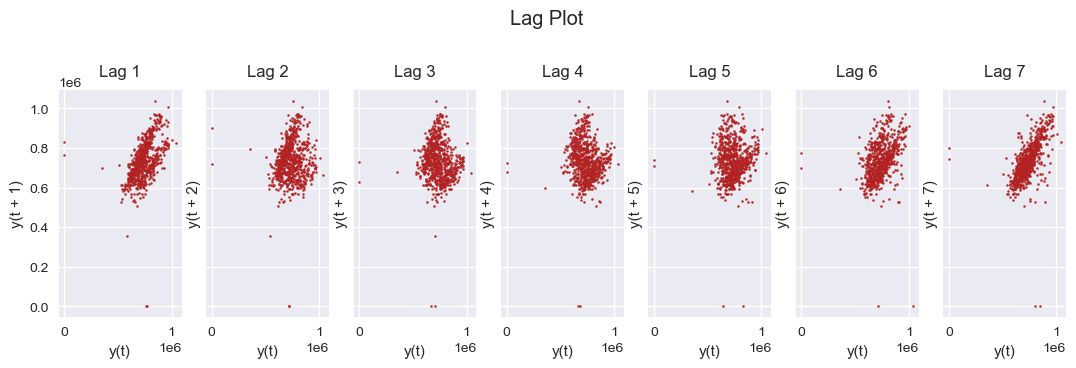

In [53]:
from pandas.plotting import lag_plot
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

# Plot
fig, axes = plt.subplots(1, 7, figsize=(13,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:7]):
    lag_plot(filt_df['nb_rides'], lag=i+1, ax=ax, c='firebrick', s=2)
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plot', y=1.15)    
plt.show()


# Benchmark Models

Hypothesis: <br>
- The time series is non stationary
- It has a trend
- It has seasonalities 
- The time series is autocorrelated

## Seasonal Naive Forecasting

Predicts the last observed value of the same season of the year. <br>
In this case there are 2 seasonalities: weekly and yearly. <br> <br>
Method 1: <br>
- Take value of same weekday one week before 

Method 2:
- Take average value of that weekday, same month but one year before

### Method 1:

In [535]:
# config filter
store = 'FR076'
filt_store = df['STORE_CODE']==store
df_store = df[filt_store].reset_index(drop=True).copy()

# create new column with seasonal naive model 1
def snaive_predict(df, index):
    prev_date = df.iloc[index]['Date'] - datetime.timedelta(days=7) # get date of same weekday the week before
    try: 
        visitors_7 = df[df['Date']==prev_date]['VISITOR_COUNT'].values[0] # get visitor count of 7 days ago
    except: 
        visitors_7 = 0 # if value of previous week is missing fil NA
    return visitors_7

df_store['snaive_pred'] = 0 # config new column for predictions

# starting at 6 to have one week of previous data 
for i in range(6, df_store.shape[0]):#df_store.shape[0]):
    pred_visitors = snaive_predict(df_store, i)
    df_store.loc[i, 'snaive_pred'] = pred_visitors

Test RMSE: 589.319


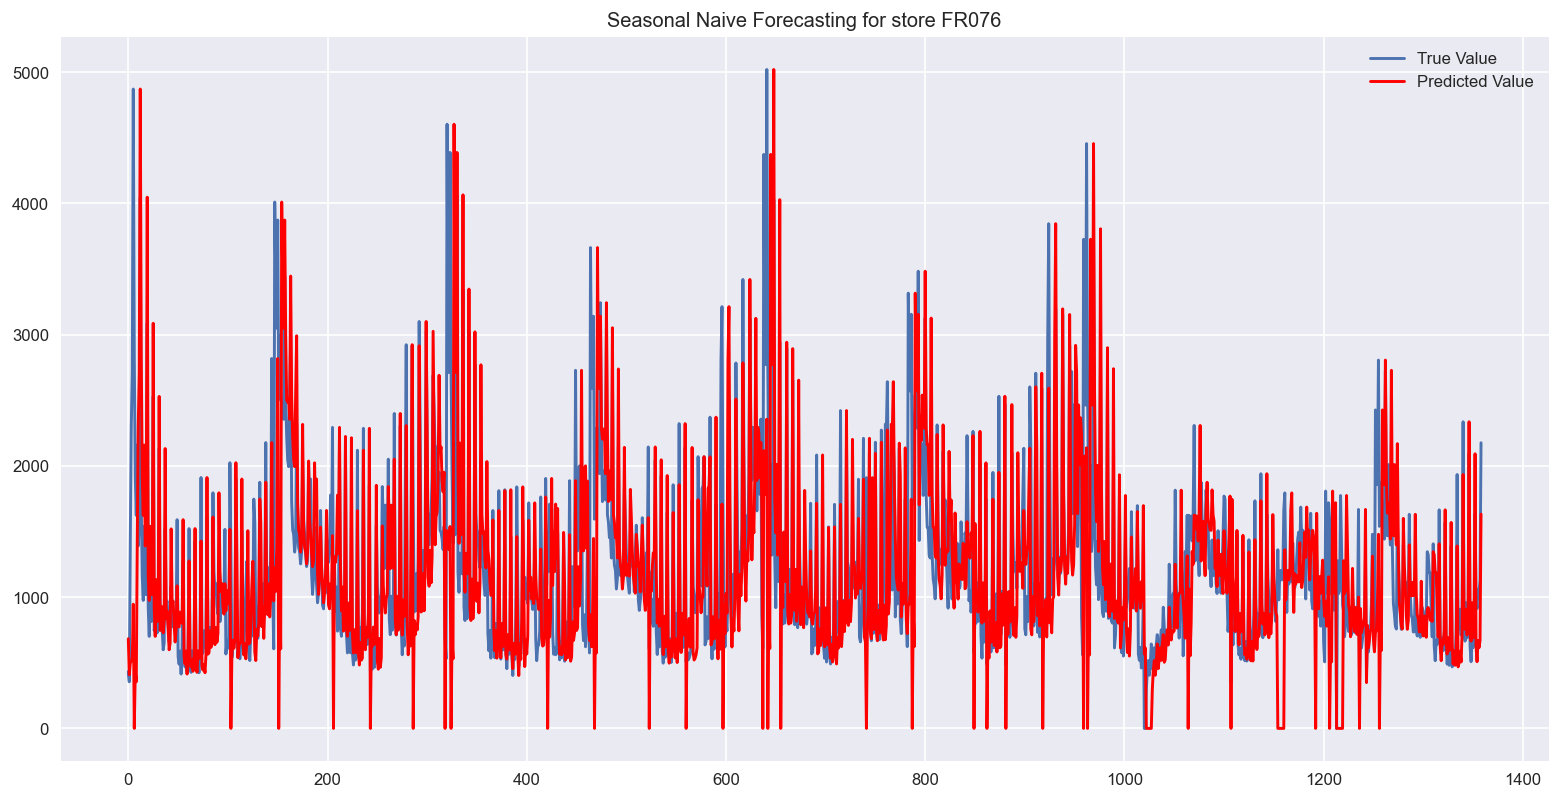

In [538]:
true_values = df_store['VISITOR_COUNT'].values[6:]
predictions = df_store['snaive_pred'].values[6:]

# evaluate forecasts
rmse = np.sqrt(mean_squared_error(true_values, predictions))
print('Test RMSE: %.3f' % rmse)

# plot forecasts against actual outcomes
plt.plot(true_values, label='True Value')
plt.plot(predictions, color='red', label='Predicted Value')
plt.legend()
plt.title(f"Seasonal Naive Forecasting for store {store}")
plt.show()

# SKIP ZEROS

## Arima

In [390]:
# preprocessing
# pick store 
store = 'FR076'
filt_store = df['STORE_CODE']==store

# keep only visitor count and set Date as index 
filt_df = df[filt_store][['Date', 'VISITOR_COUNT']].set_index('Date')

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1365
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -10500.066
Date:                Wed, 06 Apr 2022   AIC                          21012.133
Time:                        14:34:57   BIC                          21043.442
Sample:                             0   HQIC                         21023.852
                               - 1365                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6411      0.019    -32.925      0.000      -0.679      -0.603
ar.L2         -0.5798      0.022    -25.894      0.000      -0.624      -0.536
ar.L3         -0.4009      0.023    -17.306      0.0

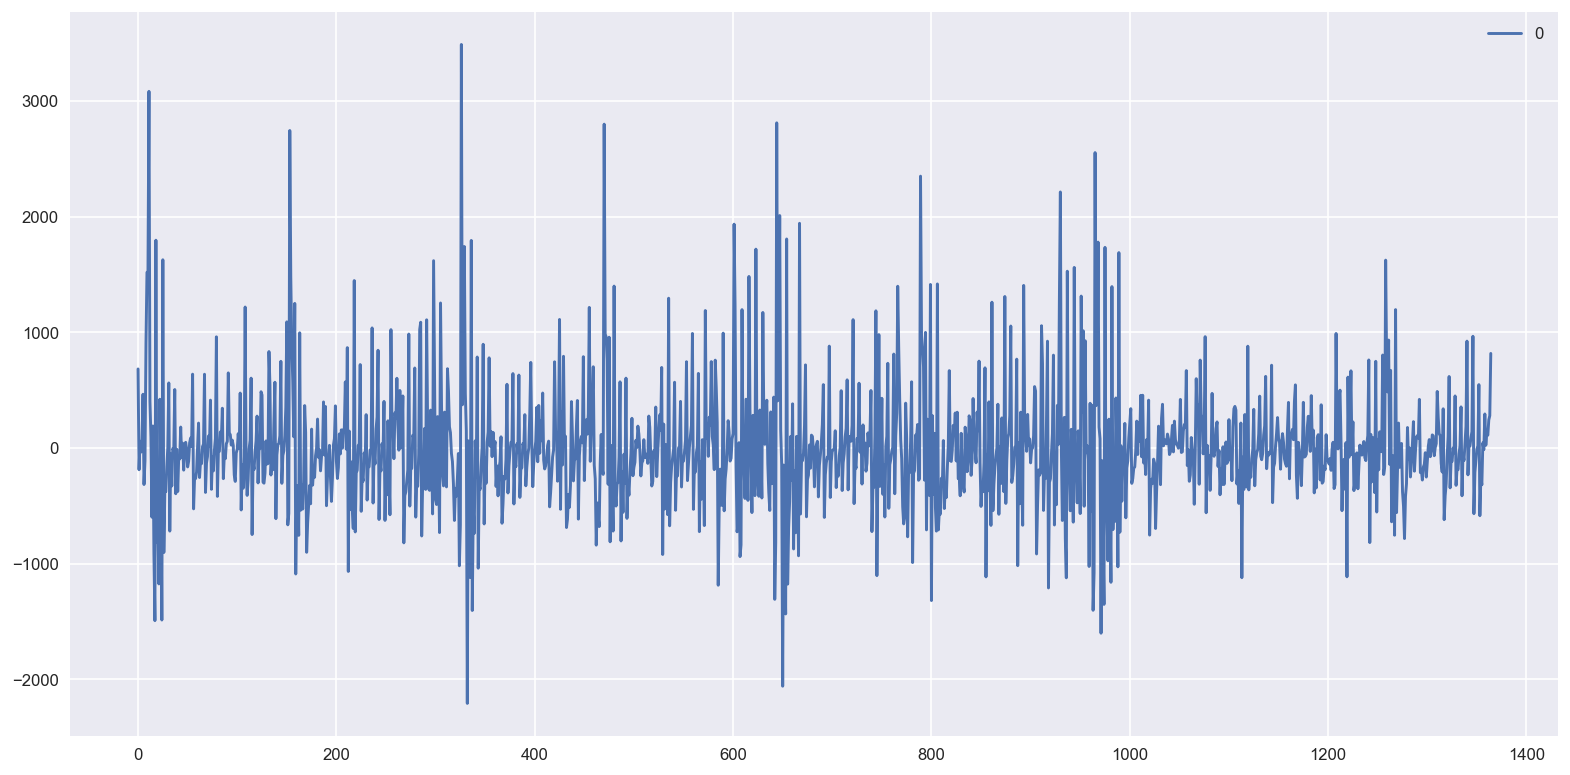

Density plot of residual errors


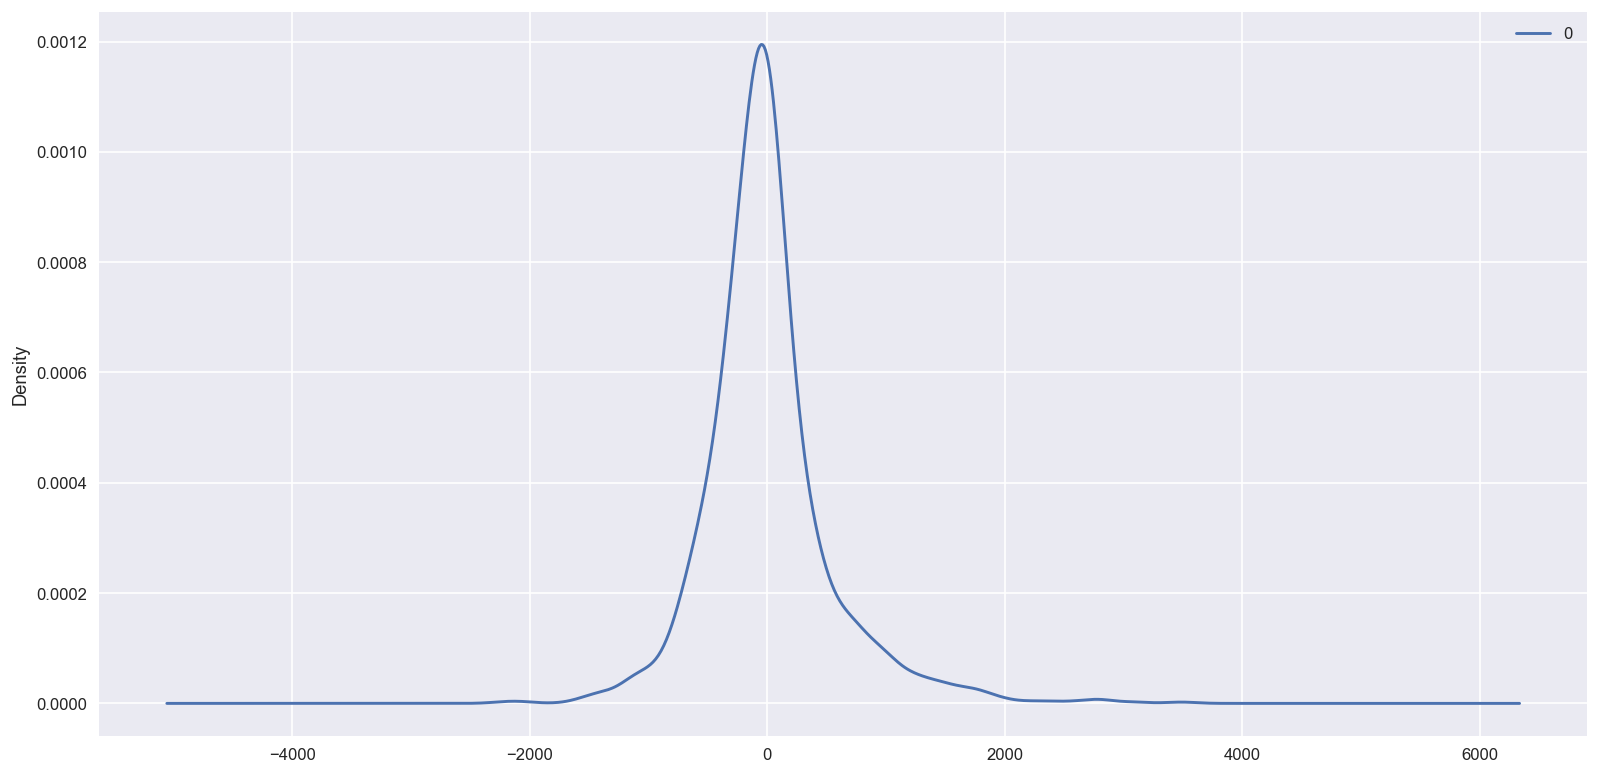

                 0
count  1365.000000
mean      2.630000
std     533.301273
min   -2208.674716
25%    -267.082598
50%     -43.465895
75%     162.075996
max    3488.631595


In [195]:
# fit model
model = ARIMA(filt_df.values, order=(5,1,0))
model_fit = model.fit()

# summary of fit model
print(model_fit.summary())

# line plot of residuals
print('Line plot of residual errors')
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

# density plot of residuals
print('Density plot of residual errors')
residuals.plot(kind='kde')
plt.show()

# summary stats of residuals
print(residuals.describe())

#### One-step forecast: <br>
Re-creating the ARIMA model after each new observation is received

In [540]:
# split into train and test sets
X = filt_df.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast() # forecasts one step into the future
    yhat = output[0]
    predictions.append(yhat) # append one-step forecast to prediction list
    obs = test[t] 
    history.append(obs) # append true value to history 
    #print('predicted=%f, expected=%f' % (yhat, obs))

In [541]:
def arima_pred(df_test, df_train):
    train_values, test_values = df_train['VISITOR_COUNT'].values, df_test['VISITOR_COUNT'].values
    history = [x for x in train_values]
    predictions = list()
    for t in range(len(test_values)):
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit()
        output = model_fit.forecast() # forecasts one step into the future
        yhat = output[0]
        predictions.append(yhat) # append one-step forecast to prediction list
        obs = test[t] 
        history.append(obs[0]) # append true value to history 
    return predictions

In [464]:
pred_arima = arima_pred(df_test=df_test, df_train=df_train)

In [466]:
len(pred_arima)

166

Test RMSE: 344.062


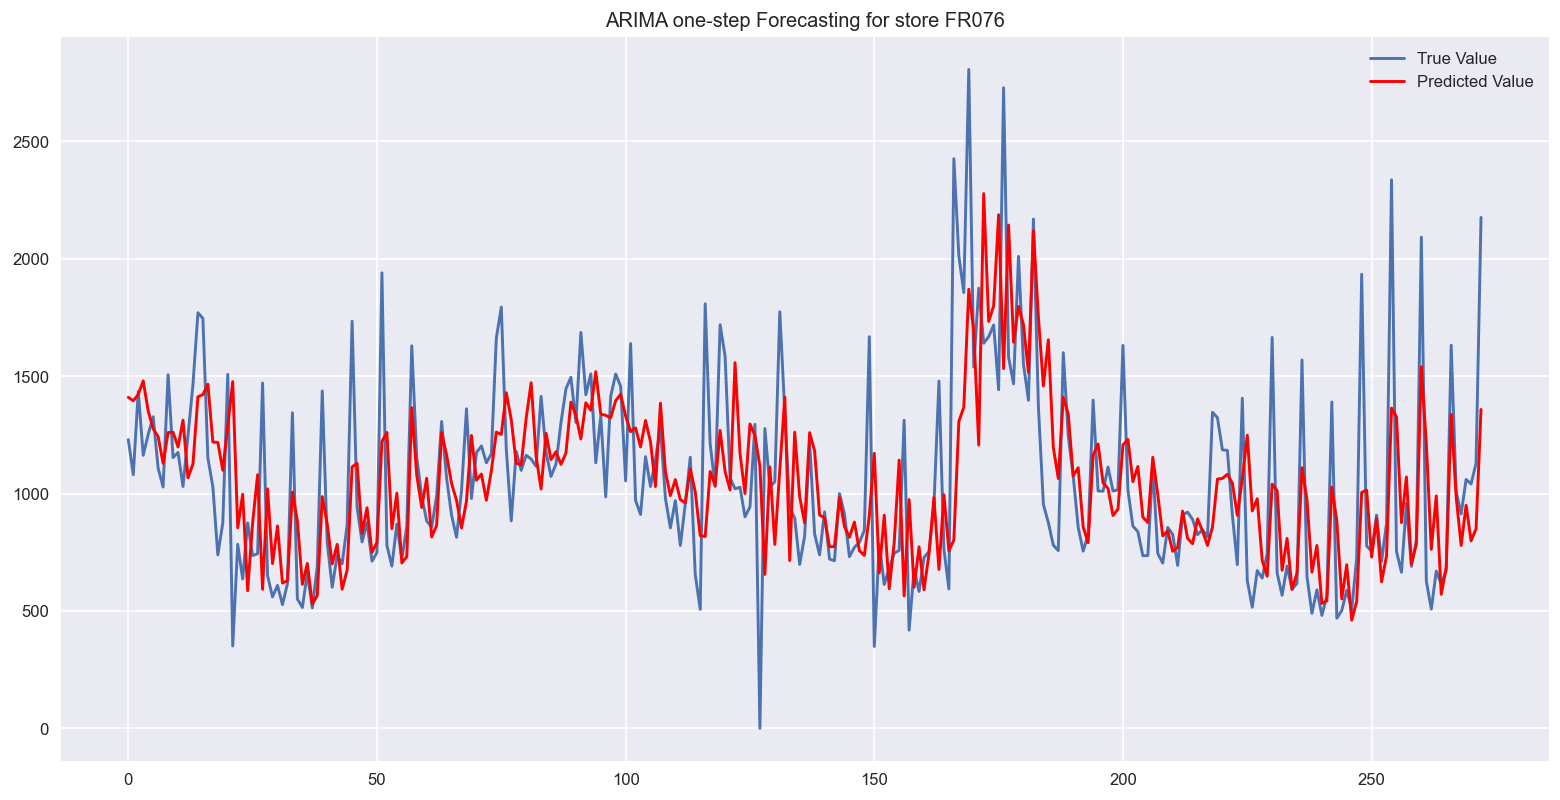

In [542]:
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test, label='True Value')
plt.plot(predictions, color='red', label='Predicted Value')
plt.legend()
plt.title(f"ARIMA one-step Forecasting for store {store}")
plt.show()

In [395]:
len(predictions)

273

In [399]:
len(train)

1092

In [400]:
filt_df[1092:]

VISITOR_COUNT
Date                     
2020-08-13         1230.0
2020-08-14         1080.0
2020-08-15         1435.0
2020-08-17         1163.0
2020-08-18         1252.0
...                   ...
2021-10-26          913.0
2021-10-27         1060.0
2021-10-28         1041.0
2021-10-29         1129.0
2021-10-30         2176.0

[273 rows x 1 columns]

#### Multi-step forecast: <br>
Adding each one-step forecast to the historical observations and re-running the ARIMA model 

In [294]:
# split into train and test sets
X = filt_df.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast() # forecasts one step into the future
    yhat = output[0]
    predictions.append(yhat) # append one-step forecast to prediction list
    #obs = test[t] 
    history.append(np.array([yhat])) # append predicted value to history 
    #print('predicted=%f, expected=%f' % (yhat, obs))

Test RMSE: 610.203


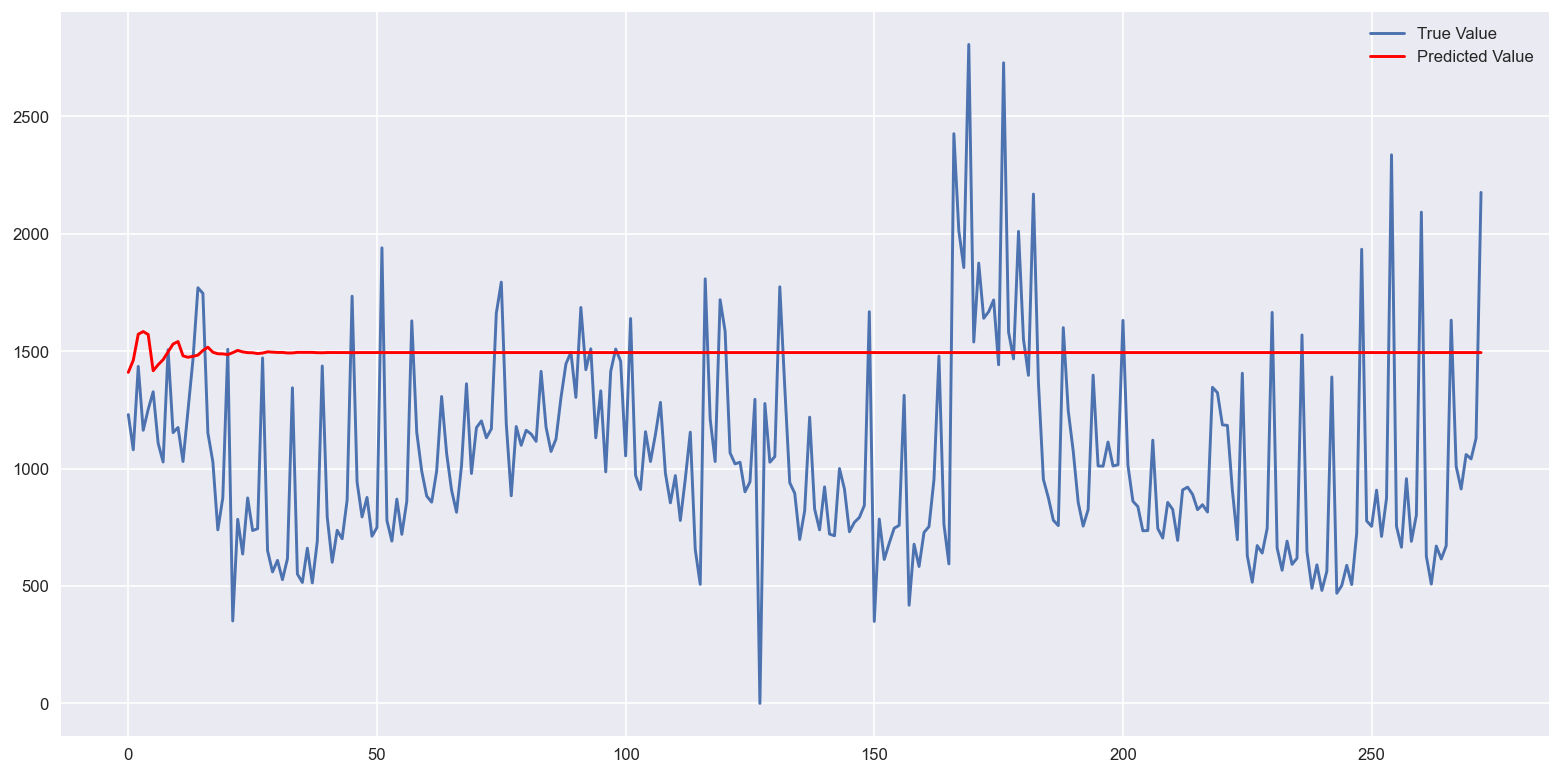

In [295]:
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test, label='True Value')
plt.plot(predictions, color='red', label='Predicted Value')
plt.legend()
plt.show()

In [311]:
model = ARIMA(history, order=(5,1,0))
model_fit = model.fit()
predictions = model_fit.forecast(steps=2) 

In [312]:
predictions

array([1494.02958084, 1494.02958084])

In [309]:
len(test[:10])

10

Test RMSE: 303.862


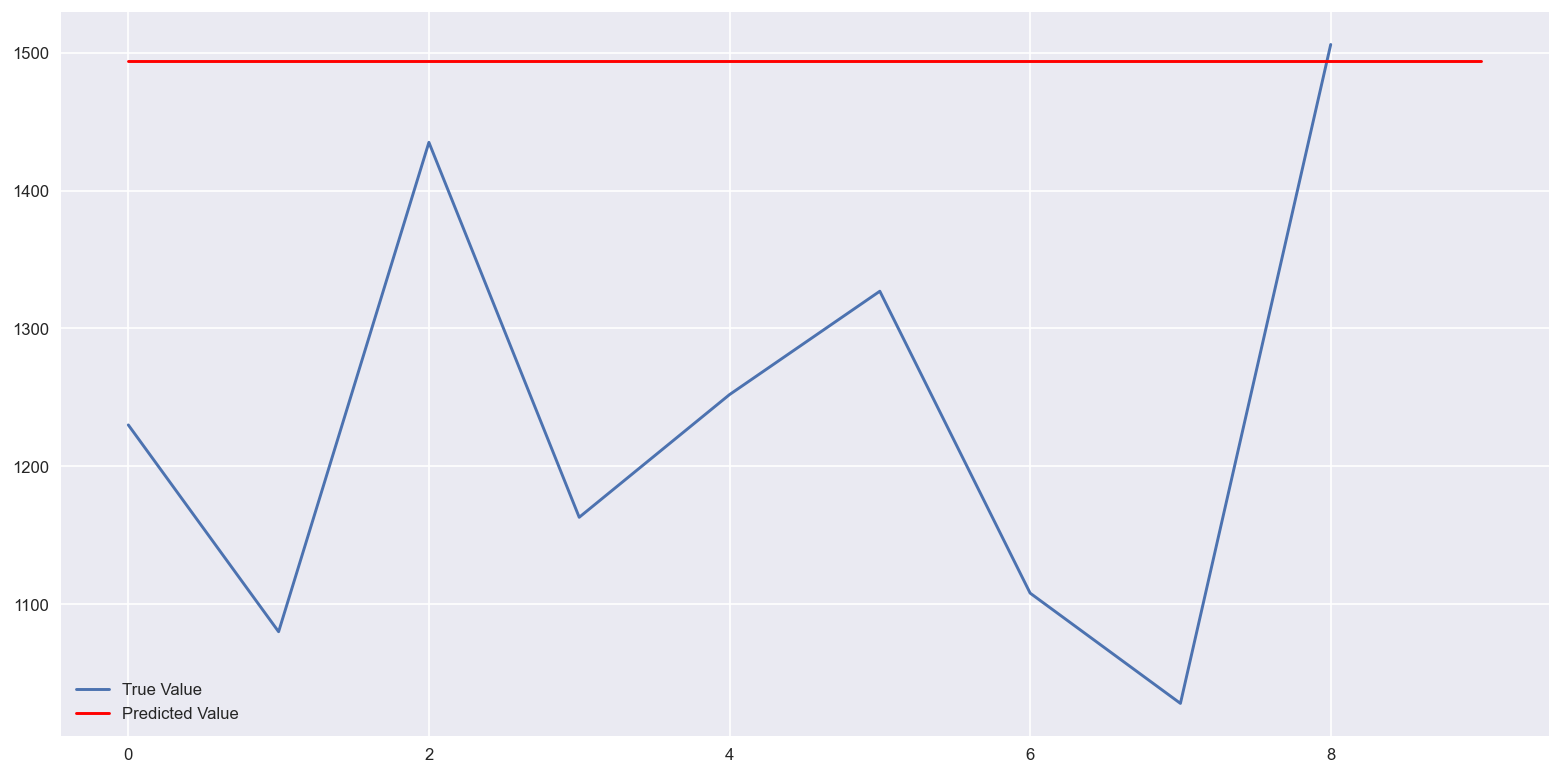

In [310]:
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test[:10], predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test[:9], label='True Value')
plt.plot(predictions, color='red', label='Predicted Value')
plt.legend()
plt.show()

## Prophet 

In [235]:
df.head()

STORE_TYPE STORE_CODE  TRANS_DATE  YEAR  MONTH  DAY  WEEK DAY_NAME  \
0  Owned boutiques      FR001  2019-05-17  2019      5   17    20      Fri   
1  Owned boutiques      FR001  2019-05-18  2019      5   18    20      Sat   
2  Owned boutiques      FR001  2019-05-20  2019      5   20    21      Mon   
3  Owned boutiques      FR001  2019-05-21  2019      5   21    21      Tue   
4  Owned boutiques      FR001  2019-05-22  2019      5   22    21      Wed   

   DISCOUNT_RATE  SALES_PERIOD  INVALID_COUNT  VISITOR_COUNT       Date  
0           0.06         False          False          369.0 2019-05-17  
1           0.01         False          False          346.0 2019-05-18  
2           0.02         False          False          316.0 2019-05-20  
3           0.01         False          False          235.0 2019-05-21  
4           0.00         False          False          237.0 2019-05-22

In [544]:
# create df pre-covid, for one store only, with date as index and visitors as only column
filt_year = df['YEAR'].isin([2017, 2018, 2019])

store = 'FR076'
filt_store = df['STORE_CODE'] == store

# create filtered df, sort by date, only keep columns Date and VISITOR_COUNT
df_proph = df[(filt_store) & (filt_year)][['Date', 'VISITOR_COUNT']].sort_values(by='Date').reset_index(drop=True)

# rename columns to fit prophet model 
df_proph.columns = ['ds', 'y']

In [545]:
# split into train and test
size = int(df_proph.shape[0] * 0.8)
train, test = df_proph[0:size], df_proph[size:df_proph.shape[0]]

# define the model
model = Prophet()
# fit model
model.fit(train)

# define dates for which we want predictions
future = test['ds'].to_frame()

# forecast future values
forecast = model.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [489]:
def pred_prophet(df_test, df_train):
    # define the model
    model = Prophet()
    # fit model
    model.fit(df_train)
    # define dates for which we want predictions
    future = df_test['ds'].to_frame()
    # forecast future values
    forecast = model.predict(future)
    y_hat = forecast['yhat'].values
    return y_hat

MAE: 314.552


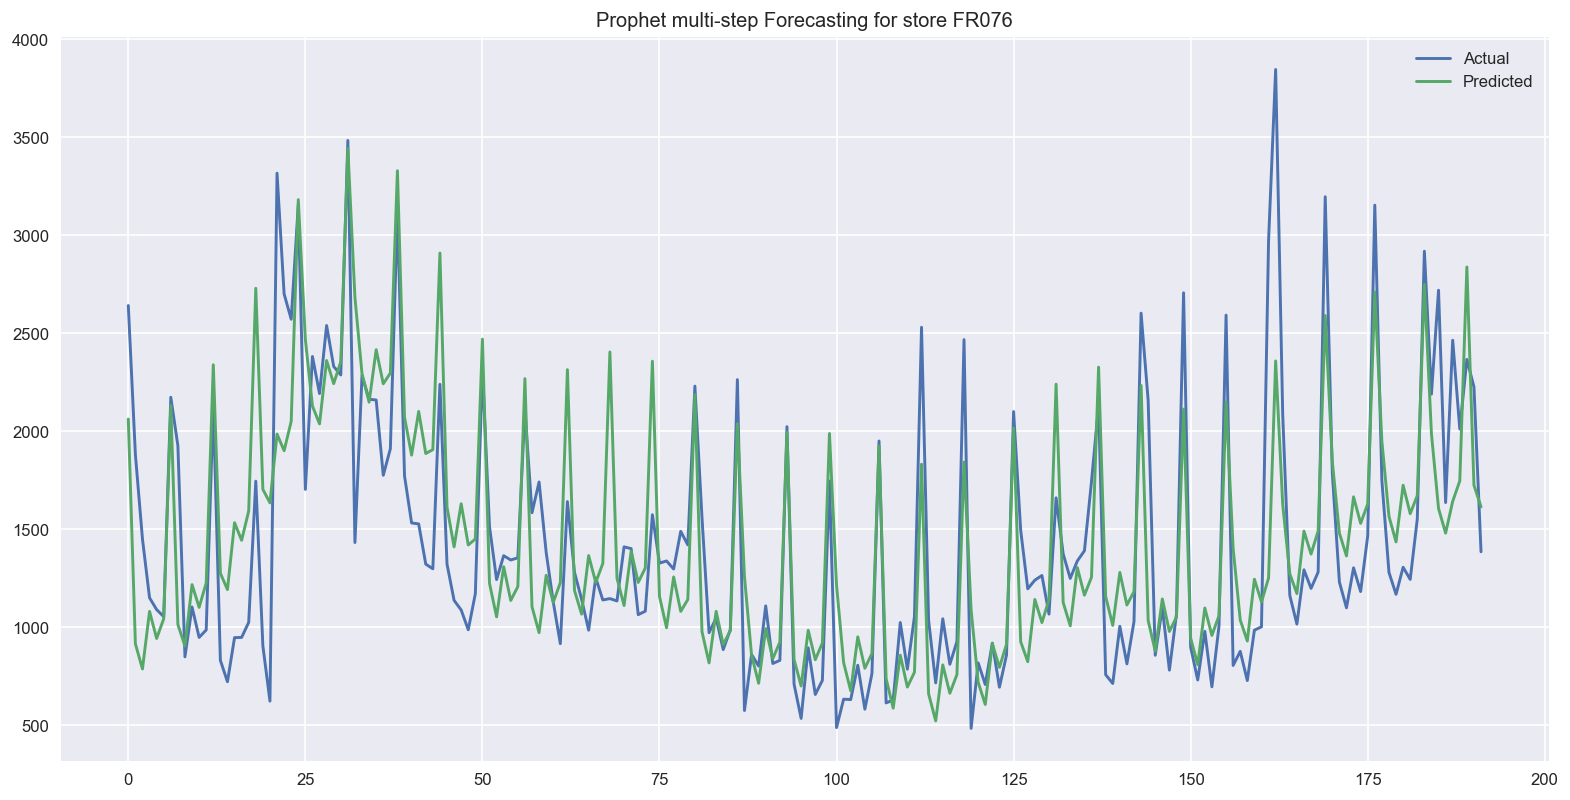

In [546]:
# calculate MAE between expected and predicted values
y_true = test['y'].values #test['y'].values
y_pred = forecast['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title(f"Prophet multi-step Forecasting for store {store}")
plt.show()

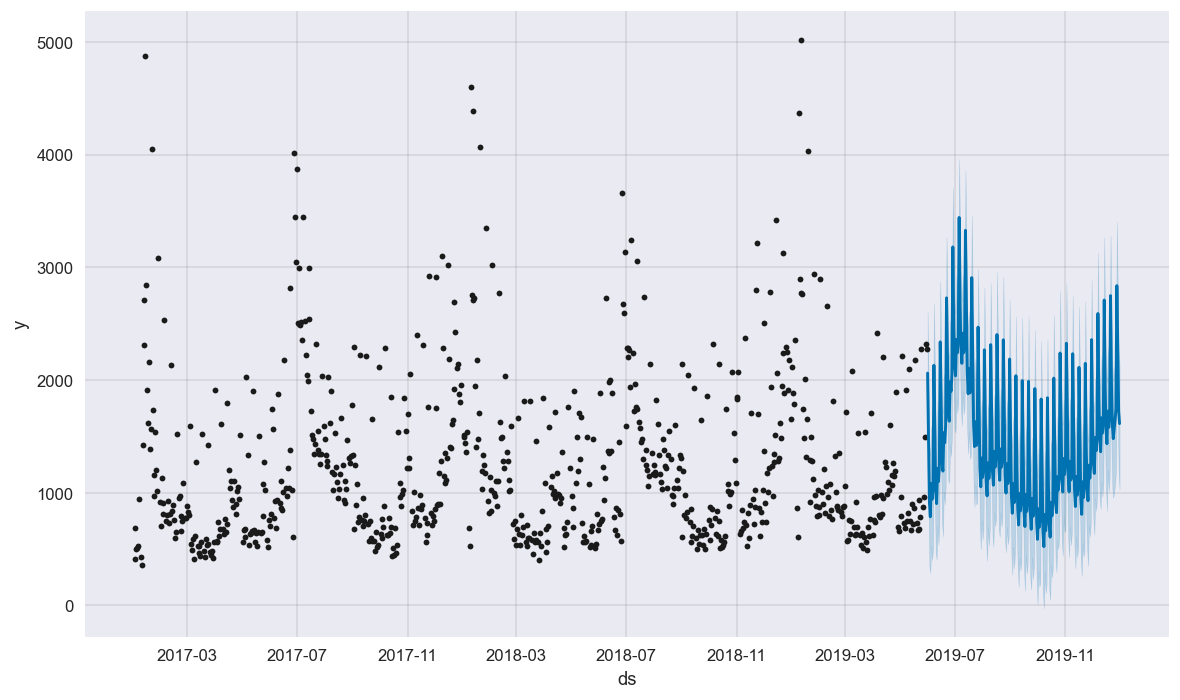

In [290]:
model.plot(forecast)
plt.show()

/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


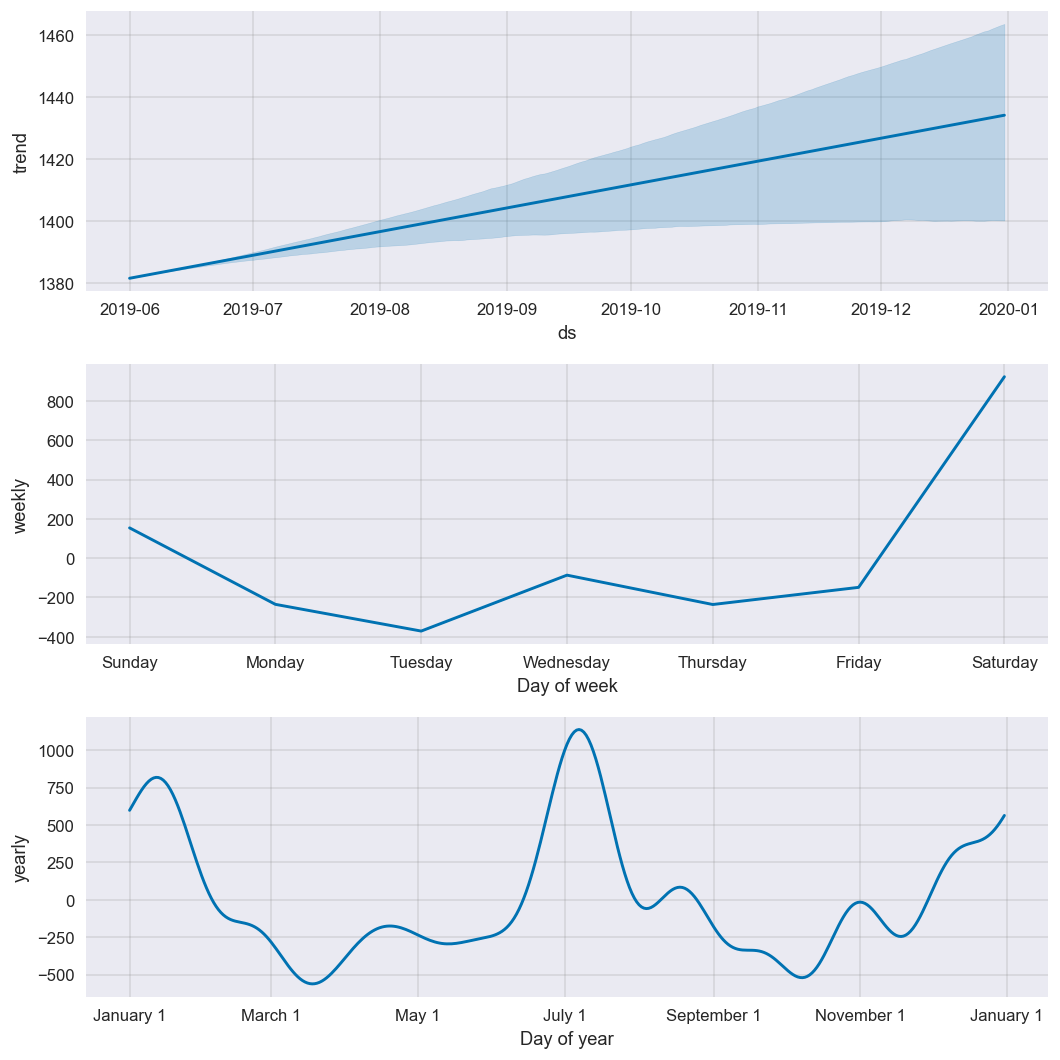

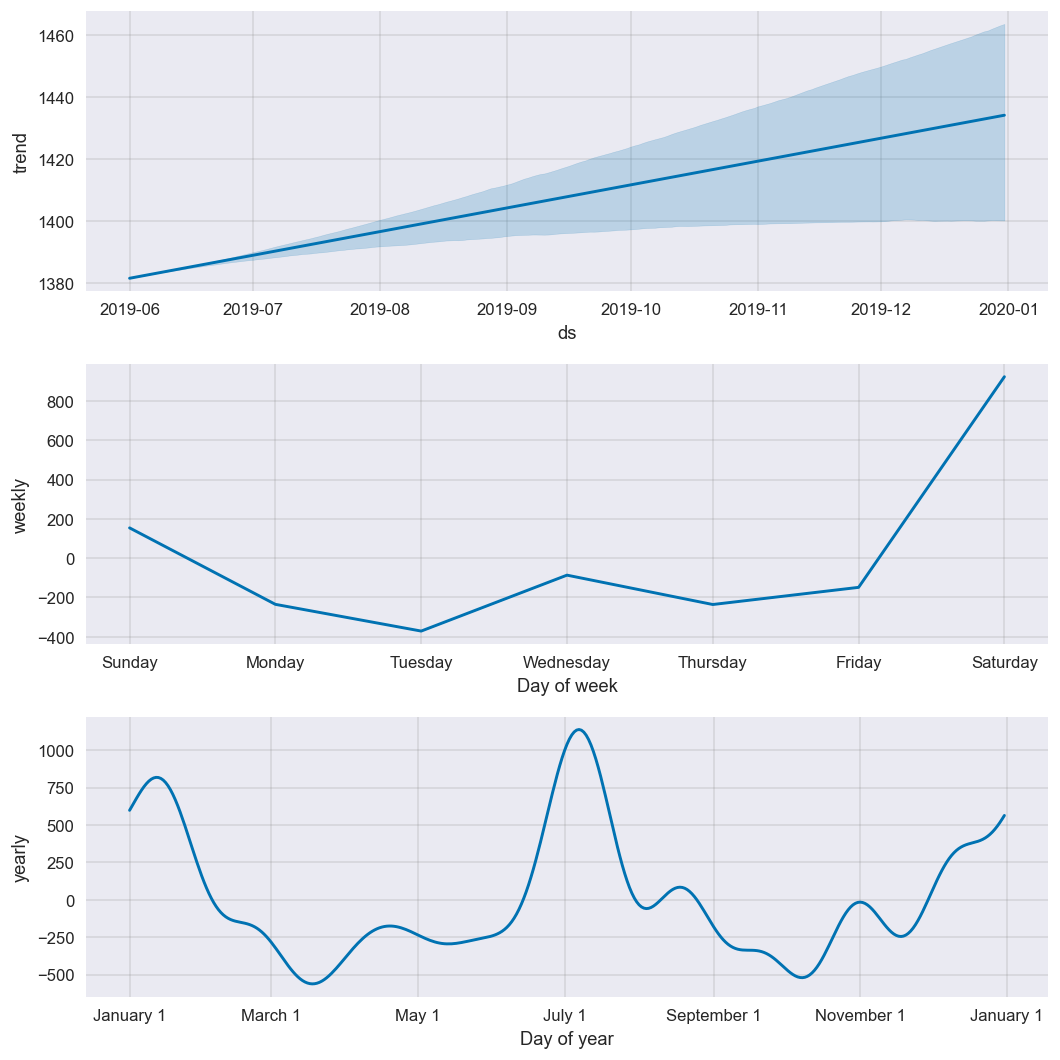

In [291]:
model.plot_components(forecast)

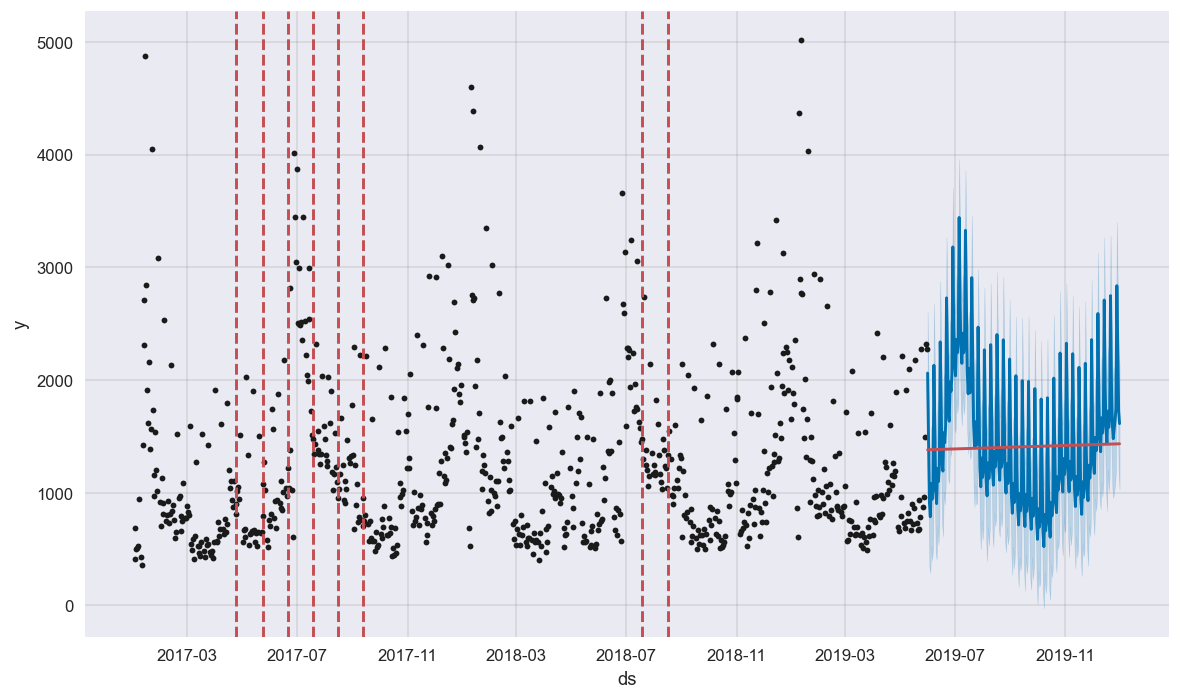

In [293]:
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

## Evaluation

Evaluation on one store FR076 <br>
Train set: 794 observations from 2017-01-02 to 2019-06-30 <br>
Test set: 166 observations from 2019-06-30 to 2019-12-30

In [414]:
## Prep dataset

# only one stor
store = 'FR076'
filt_store = df['STORE_CODE']==store

# only pre-covid data
filt_year = df['YEAR'].isin([2017, 2018, 2019])

df_store = df[(filt_store)&(filt_year)][['Date','VISITOR_COUNT']].reset_index(drop=True).copy()

In [416]:
# get naive predictions
# starting at 6 to have one week of previous data 
for i in range(6, df_store.shape[0]):
    pred_visitors = snaive_predict(df_store, i)
    df_store.loc[i, 'snaive_pred'] = pred_visitors

In [503]:
snaive_yhat = df_store[df_store['Date']>='2019-07-01']['snaive_pred'].values

In [412]:
# split in train and test
df_train = df_store[df_store['Date']<'2019-07-01'][['Date','VISITOR_COUNT']].copy()
df_test = df_store[df_store['Date']>='2019-07-01'][['Date','VISITOR_COUNT']].copy()

In [413]:
# get ARIMA predictions
df_test

Date  VISITOR_COUNT
794 2019-07-01         2381.0
795 2019-07-02         2192.0
796 2019-07-03         2539.0
797 2019-07-04         2330.0
798 2019-07-05         2287.0
..         ...            ...
955 2019-12-26         2464.0
956 2019-12-27         2011.0
957 2019-12-28         2366.0
958 2019-12-30         2226.0
959 2019-12-31         1385.0

[166 rows x 2 columns]

In [496]:
arima_yhat = np.array(arima_pred(df_test=df_test, df_train=df_train))

In [497]:
len(arima_yhat)

166

In [474]:
# get PROPHET predictions
# rename columns to fit prophet model 
df_proph_train = df_train.copy()
df_proph_train.columns = ['ds', 'y']
df_proph_test = df_test.copy()
df_proph_test.columns = ['ds', 'y']

In [491]:
prophet_yhat = pred_prophet(df_proph_test, df_proph_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/marthab/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [494]:
len(prophet_yhat)

166

In [506]:
# put real values naive, arima, and prophet predictions in one df
df_eval = df_test.copy()
df_eval['snaive_pred'] = snaive_yhat
df_eval['arima_pred'] = arima_yhat
df_eval['prophet_pred'] = prophet_yhat

In [507]:
df_eval

Date  VISITOR_COUNT  snaive_pred   arima_pred  prophet_pred
794 2019-07-01         2381.0        905.0  1296.081723   2085.025650
795 2019-07-02         2192.0        623.0  2499.961571   1990.159346
796 2019-07-03         2539.0       3316.0  1796.392899   2333.666814
797 2019-07-04         2330.0       2700.0  1882.842610   2221.065147
798 2019-07-05         2287.0       2571.0  2121.590469   2336.038098
..         ...            ...          ...          ...           ...
955 2019-12-26         2464.0       1244.0   741.004343   1618.239180
956 2019-12-27         2011.0       1552.0  1000.678995   1718.404367
957 2019-12-28         2366.0       2918.0   676.157729   2807.423334
958 2019-12-30         2226.0       2719.0  1003.450105   1704.292542
959 2019-12-31         1385.0       1636.0   755.551939   1582.499505

[166 rows x 5 columns]

Evaluation: <br> <br>
MASE <br> 
A scaled error is less than one if it arises from a better forecast than the average naïve forecast computed on the training data. Conversely, it is greater than one if the forecast is worse than the average naïve forecast computed on the training data.

In [518]:
def mase(y, y_hat, y_naive):
    
    mae_naive = mean_absolute_error(y, y_naive) # MAE of naive method
    
    mae_model = mean_absolute_error(y, y_hat) # MAE of model to be evaluated
    
    return mae_model/mae_naive

In [517]:
# MAE for each model 
mae_snaive = mean_absolute_error(df_eval['VISITOR_COUNT'].values, df_eval['snaive_pred'].values)
mae_arima = mean_absolute_error(df_eval['VISITOR_COUNT'].values, df_eval['arima_pred'].values)
mae_prophet = mean_absolute_error(df_eval['VISITOR_COUNT'].values, df_eval['prophet_pred'].values)
print(mae_snaive, mae_arima, mae_prophet)

344.19879518072287 605.7973564735383 288.0098847596224


In [521]:
# MASE for each model 
mase_arima = mase(df_eval['VISITOR_COUNT'].values, df_eval['arima_pred'].values, df_eval['snaive_pred'].values)
mase_prophet = mase(df_eval['VISITOR_COUNT'].values, df_eval['prophet_pred'].values, df_eval['snaive_pred'].values)
print(mase_arima, mase_prophet)

1.7600217227822141 0.8367544825611657
